# Entrainer les agents addi

## Settings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%reset -f

In [ ]:
%cd /content/drive/MyDrive/RECHERCHE3
%ls

/content/drive/Othercomputers/Mon MacBook Pro/google_saved/RECHERCHE3
ddqn_lib/  GCN/       Hamilton.zip  model_vNet.h5  transformer/
Euler/     GCN.zip    model_1.h5    Pinns/         transformer_old/
Euler2/    Hamilton/  model_2.h5    popup_lib/     translations/


In [ ]:
#ou bien 
#!cp -r drive/MyDrive/permanent/RECHERCHE2/ml_flux_euler/* .

In [ ]:
import Euler2.core_solver as core
import Euler2.agent_addi as aga
import Euler2.neural_networks as nn

from Euler2.param import Param,Projecter
from Euler2.initial_conditions import *

#from Euler.backend import K
import matplotlib.pyplot as plt
import popup_lib.popup as pop
import numpy as np
import copy
import time

import tensorflow as tf

Popup loaded!


Attention: `BC_periodic` rajoute une discontinuité au bord pour chaque fonction non périodique.




In [ ]:
param = Param(nx=1000,nx_ratio=10,
              BC_solver=Param.BC_reflexive,
              BC_model=Param.BC_reflexive)
nb_t=800

Param initialised with, nx=1000, nx_coarse=99


## Génération des données

In [ ]:
def show_w_init(W):
    fig,axs=plt.subplots(3,3,sharex="all",sharey="all",figsize=(6,6))
    axs=axs.flatten()

    for i in range(9):
        axs[i].plot(W[i,:,0],label=r"$\rho$")
        axs[i].plot(W[i,:,1],label=r"$\rho V$")
        axs[i].plot(W[i,:,2],label="$E$")
    plt.legend()
    plt.show()

(9, 1000, 3)


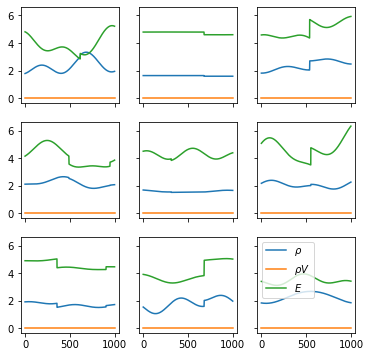

In [ ]:
res=init_non_periodic(param,9)
print(res.shape)
show_w_init(res)

(10, 1000, 3)


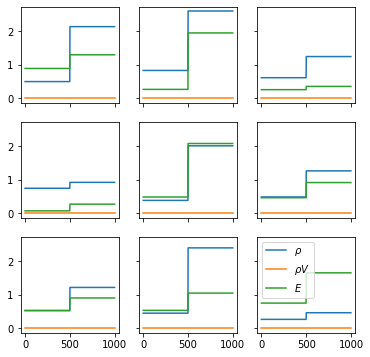

In [ ]:
#attention, si les random sod vont trop proche de zéro => ça pète
res= init_random_sod(param, batch_size=10, minimum_E=0.05, maximal_jump_E=2, minimum_rho=0.05, maximal_jump_rho=2)
print(res.shape)
show_w_init(res)

* Il faut mettre des jeux d'entrainement assez gros pour limiter le hasard du sampling
* Quand, au bout d'une longue stagnation, tous les agents s'améliore d'un coup, c'est suspect ! 
* On ne peut pas mettre non plus des batchs trop gros à cause de la limite des GPU;  cela bloque très vite ex de jeu qui passe pas: 

        nb_t=1000, batch_size = 140, nx=1000.  

In [ ]:
def data_for_train():
    return init_non_periodic(param,120)

Il est tout à fait possible de mettre dans val des K-tests déterministes

In [ ]:
def data_for_val():
    return init_non_periodic(param,120)

### Test du solveur

In [ ]:
def generate_fine_solutions(for_train):
    if for_train:
        w_init=data_for_train()
    else:
        w_init=data_for_val()

    
    return core.compute_solutions(param, nb_t, w_init,False)
W_val=generate_fine_solutions(True)
W_val.shape

traçage de la fonction 'compute_solutions_order1' avec les arguments primitif:
		 nb_t,dt_over_dx,dt_over_dx_coarse,nx,nx_coarse,BC_solver,gamma,is_coarse=
		 800 0.1 0.009899999999999999 1000 99 reflexive 1.4 False
		 et le tenseurs W_init de shape: (120, 1000, 3)


TensorShape([800, 120, 1000, 3])

## Entrainement

### Définition des familles d'agent

In [ ]:
fam_size=6
#un durée pour que les agents puissent tous faire leur 'nb_optimization' optimizations
#attention, cela dépend beaucoup de la watch_duration
period_duration="6 steps"#"15 seconds" 
all_agents=[]

In [ ]:
def family_full(window_size,color):
        name="full_"+str(window_size)
        agents=[]
        model_struct = (32,64,32)
        for _ in range(fam_size):
            model=nn.Difference_model_several_convo(param,4)
                 
            agent= aga.Agent_addi(param, 
                            model,
                            watch_duration=20, #20
                            lossCoef_stab=100, #10.
                            lossCoef_ridge=1e-3,
                            lossCoef_disHLL=1,
                            nb_optimization=15,
                            )
            agents.append(agent)
            all_agents.append(agent)
            
        return pop.Family_trainer(
            agents=agents,
            nb_bestweights_averaged=3,
            nb_strong=3,
            nb_weak=2,
            period_duration=period_duration,
            name=name,
            color=color)

family_trainers=[
                 family_full(5,"red"),
                 #family_full(7,"blue"),
                 ]



In [ ]:
def load_data():
    ti=time.time()
    W_train = generate_fine_solutions(True)
    W_val = generate_fine_solutions(False)
    print(f"|génération des données, durée: {time.time()-ti:.2f} ",end="")
    
    ti=time.time()
    for agent in all_agents:
        agent.load_WY_train(W_train)
        agent.load_WY_valid(W_val)
    print(f"|load données,durée: {time.time()-ti:.2f}",end="")

### LA BOUCLE

In [ ]:
try:
    for i in range(50):
        load_data()
        for family_trainer in family_trainers:
            family_trainer.period()
except KeyboardInterrupt:
    for family_trainer in family_trainers:
        #pour pouvoir reprendre si on veut
        family_trainer.interupt_period()

|génération des données, durée: 1.77 traçage de la méthode _load_WY_accelerated2 pour les paramètres: W:(800, 120, 1000, 3), nx_ratio:10
|load données,durée: 0.26
full_5,échauffement Traçage de la méthode gradient_tape avec les tenseurs w_init:(256, 99, 3), w_final:(256, 99, 3)
		et les primitifs BC_solver, gamma, dt_over_dx_coarse
		 reflexive 1.4 0.009899999999999999
Traçage de la méthode gradient_tape avec les tenseurs w_init:(256, 99, 3), w_final:(256, 99, 3)
		et les primitifs BC_solver, gamma, dt_over_dx_coarse
		 reflexive 1.4 0.009899999999999999
traçage de la méthode _predict_accelerated avec les arguments primitifs
		is_model,  BC_solver, gamma, dt_over_dx_coarse
		 False reflexive 1.4 0.009899999999999999
		et le tenseur w_init de shape (120, 99, 3)
traçage de la méthode _predict_accelerated avec les arguments primitifs
		is_model,  BC_solver, gamma, dt_over_dx_coarse
		 True reflexive 1.4 0.009899999999999999
		et le tenseur w_init de shape (120, 99, 3)
a↗1.023Traçage de la

/content/drive/Othercomputers/Mon MacBook Pro/google_saved/RECHERCHE3/popup_lib/popup.py:450: RuntimeWarning: invalid value encountered in double_scalars
  if strong.best_score>sco+np.abs(sco)*0.5:


|génération des données, durée: 1.65 |load données,durée: 0.01
full_5,period:11 -b↗1.9224-d↗2.1162-f↗1.7756, mutations:c⇇c⇇d⇇b|d⇇e⇇c⇇e⇇a⇇d||génération des données, durée: 1.66 |load données,durée: 0.01
full_5,period:12 ------, mutations:e⇇a⇇c⇇f⇇b|f⇇c⇇a⇇e||génération des données, durée: 1.67 |load données,durée: 0.01
full_5,period:13 ------, mutations:a⇇c⇇e⇇a⇇d|c⇇c⇇d⇇b⇇d||génération des données, durée: 1.66 |load données,durée: 0.01
full_5,period:14 a↗2.2399-c↗2.1166---, mutations:b⇇c⇇e⇇f⇇e⇇a⇇d⇇d|d⇇e⇇c⇇e⇇a⇇d⇇a||génération des données, durée: 1.62 |load données,durée: 0.01
full_5,period:15 ------, mutations:e⇇a⇇c⇇f⇇b⇇d|f⇇c⇇a⇇e⇇c||génération des données, durée: 1.65 |load données,durée: 0.01
full_5,period:16 ------, mutations:f⇇c⇇a⇇e⇇c⇇c|c⇇c⇇d⇇b⇇d⇇d||génération des données, durée: 1.64 |load données,durée: 0.01
full_5,period:17 -b↗1.937c↗2.4269-e↗2.0214f↗2.0039, mutations:d⇇e⇇c⇇e⇇a⇇d⇇a⇇c|b⇇c⇇e⇇f⇇e⇇a⇇d⇇d⇇a||génération des données, durée: 1.66 |load données,durée: 0.01
full_5,period:18 ----

### Historique des `famparams`

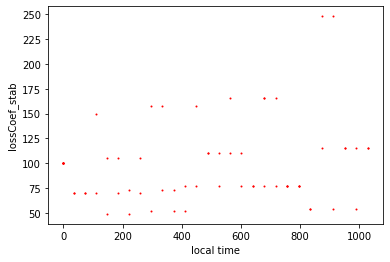

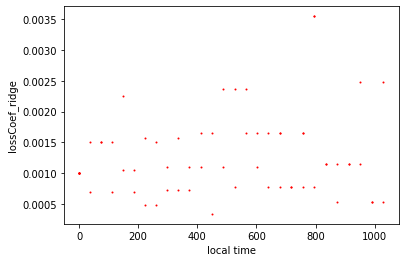

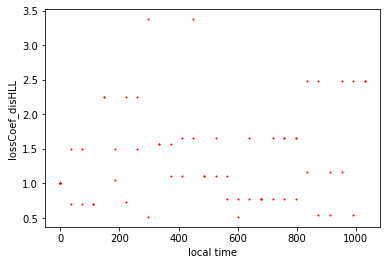

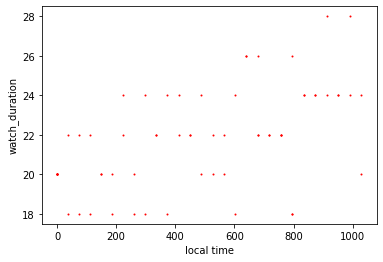

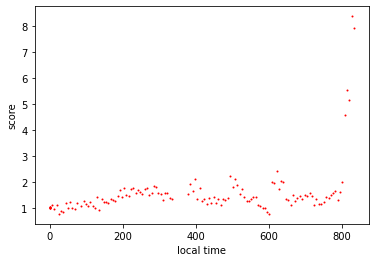

In [ ]:
def plot_history_famparams():
    # keys=["lossCoef_stab","lossCoef_ridge","lossCoef_disHLL","lossCoef_Laplacian","watch_duration","score"]
    keys=["lossCoef_stab","lossCoef_ridge","lossCoef_disHLL","watch_duration","score"]

    for k in keys:
        fig,ax=plt.subplots()
        for family_trainer in family_trainers:
            family_trainer.plot_metric(k,ax)

    plt.show()
plot_history_famparams()

### Historique des `loss`

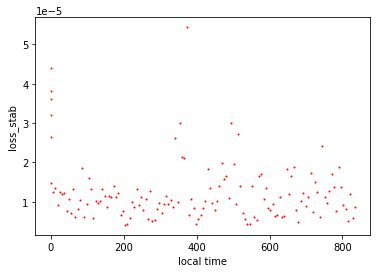

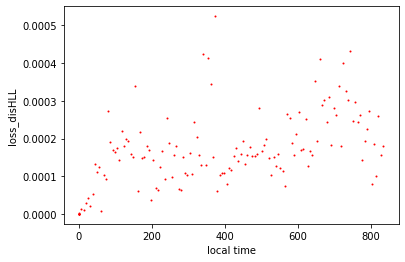

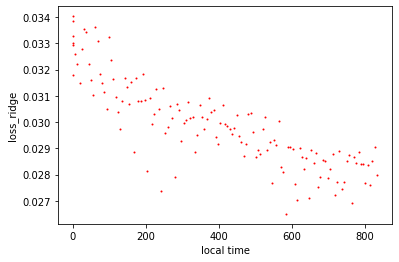

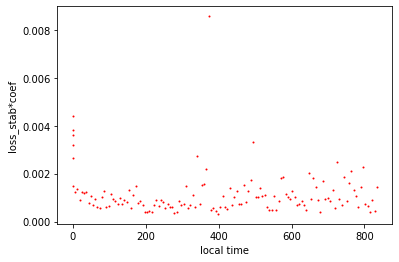

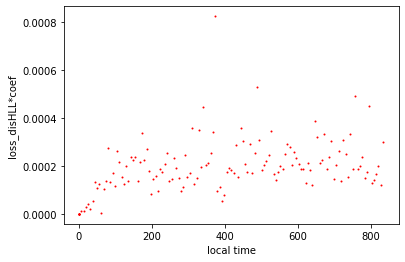

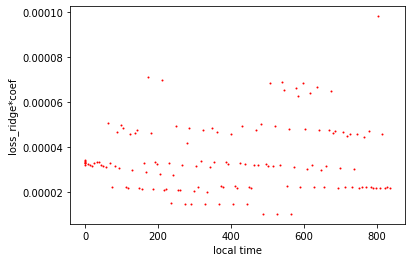

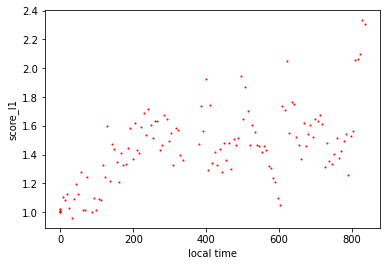

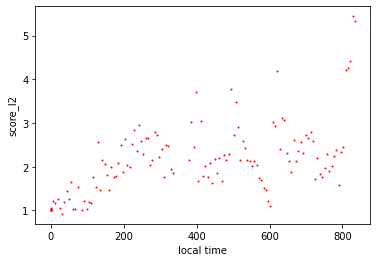

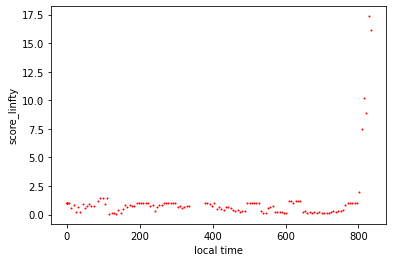

In [ ]:
def plot_history_losses():
    # keys=["loss_stab","loss_disHLL","loss_ridge","loss_Laplacian"]
    keys=["loss_stab","loss_disHLL","loss_ridge",
          "loss_stab*coef","loss_disHLL*coef","loss_ridge*coef",
          "score_l1","score_l2","score_linfty"
          ]

    for k in keys:
        fig,ax=plt.subplots()
        for family_trainer in family_trainers:
            family_trainer.plot_metric(k,ax)

    plt.show()
plot_history_losses()

## Choix d'une des familles

In [ ]:
family_trainer=family_trainers[0]

### Valeurs des famparams

In [ ]:

for name,agent_w in family_trainer.agents.items():
    print(name)
    print(agent_w.agent.famparams)
    print(agent_w.agent.agent_score())


best_agent=family_trainer.get_best_agent()
# best_agent=family_trainer.agents['a'].agent
print("best agent")
print(best_agent.famparams)
# print(best_agent.agent_score())


a
{'lossCoef_stab': 115.76249999999999, 'lossCoef_ridge': 0.000540225, 'lossCoef_disHLL': 2.4806249999999994, 'watch_duration': 20}
nan
b
{'lossCoef_stab': 115.76249999999999, 'lossCoef_ridge': 0.0024806249999999998, 'lossCoef_disHLL': 2.4806249999999994, 'watch_duration': 24}
nan
c
{'lossCoef_stab': 77.175, 'lossCoef_ridge': 0.0016537499999999998, 'lossCoef_disHLL': 1.6537499999999996, 'watch_duration': 22}
nan
d
{'lossCoef_stab': 77.175, 'lossCoef_ridge': 0.00077175, 'lossCoef_disHLL': 0.7717499999999998, 'watch_duration': 22}
nan
e
{'lossCoef_stab': 77.175, 'lossCoef_ridge': 0.00077175, 'lossCoef_disHLL': 0.7717499999999997, 'watch_duration': 26}
nan
f
{'lossCoef_stab': 165.375, 'lossCoef_ridge': 0.00077175, 'lossCoef_disHLL': 1.6537499999999996, 'watch_duration': 22}
nan
best agent
{'lossCoef_stab': 77.175, 'lossCoef_ridge': 0.00077175, 'lossCoef_disHLL': 0.7717499999999997, 'watch_duration': 26}


## Testons le long du temps

In [ ]:
def compare_along_the_time(W_val):
    nb_t = len(W_val)
    
    best_agent.load_WY_valid(W_val)
    res_fine_proj,res_HLL,res_model=best_agent.predict()
        
    nb_batch_plot=5
    if nb_batch_plot>W_val.shape[1]:
        nb_batch_plot=W_val.shape[1]
    
    nb_t_plot=3
    #pour avoir le permier temps et le dernier
    t_to_plot=np.floor(np.linspace(0,nb_t-1,nb_t_plot)).astype(int)
    if nb_batch_plot==1:ax=ax[:,tf.newaxis]
    
    fig, ax = plt.subplots(nb_t_plot,nb_batch_plot,figsize=(15,nb_t_plot*2))
    for i,t in enumerate(t_to_plot):
        for j in range(nb_batch_plot):
            ax[i,j].plot(res_fine_proj[t,j,:,0],color="k",label="fine")
            ax[i,j].plot(res_HLL[t,j,:,0],color="b",label="HLL")
            ax[i,j].plot(res_model[t,j,:,0],color="r",label="model")
    ax[0,0].legend()    
    ax[0,0].set_title("Rho")
    fig.tight_layout()


    fig, ax = plt.subplots(nb_t_plot,nb_batch_plot,figsize=(15,nb_t_plot*2))
    for i,t in enumerate(t_to_plot):
        for j in range(nb_batch_plot):
            ax[i,j].plot(res_fine_proj[t,j,:,2],color="k",label="fine")
            ax[i,j].plot(res_HLL[t,j,:,2],color="b",label="HLL")
            ax[i,j].plot(res_model[t,j,:,2],color="r",label="model")
    ax[0,0].legend()    
    ax[0,0].set_title("Energie")
    fig.tight_layout()


    errors_HLL=tf.reduce_mean(tf.abs(res_fine_proj-res_HLL),axis=[1,2,3])
    errors_model=tf.reduce_mean(tf.abs(res_fine_proj-res_model),axis=[1,2,3])
    
    fig,ax=plt.subplots()
    ax.plot(errors_HLL,color="b",label="HLL")
    ax.plot(errors_model,color="r",label="model")

    # if (np.max(errors_model)>0.1):
    #     ax.set_ylim(0,0.1)
    
    ax.legend()
    ax.set_xlabel("time")

    plt.show()

### kind Periodic

traçage de la fonction 'compute_solutions_order1' avec les arguments primitif:
		 nb_t,dt_over_dx,dt_over_dx_coarse,nx,nx_coarse,BC_solver,gamma,is_coarse=
		 800 0.1 0.009899999999999999 1000 99 periodic 1.4 False
		 et le tenseurs W_init de shape: (50, 1000, 3)
(800, 50, 1000, 3)
traçage de la méthode _load_WY_accelerated2 pour les paramètres: W:(800, 50, 1000, 3), nx_ratio:10
traçage de la méthode _predict_accelerated avec les arguments primitifs
		is_model,  BC_solver, gamma, dt_over_dx_coarse
		 True periodic 1.4 0.009899999999999999
		et le tenseur w_init de shape (50, 99, 3)
traçage de la méthode _predict_accelerated avec les arguments primitifs
		is_model,  BC_solver, gamma, dt_over_dx_coarse
		 False periodic 1.4 0.009899999999999999
		et le tenseur w_init de shape (50, 99, 3)


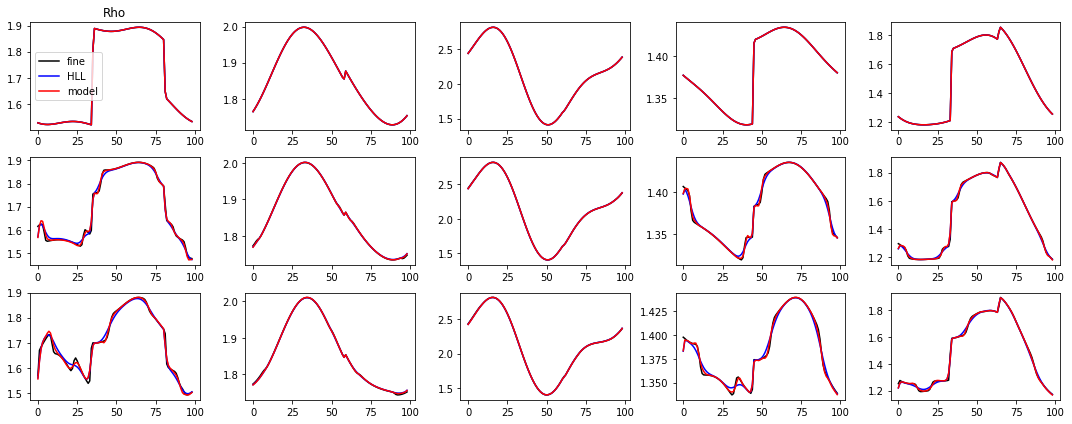

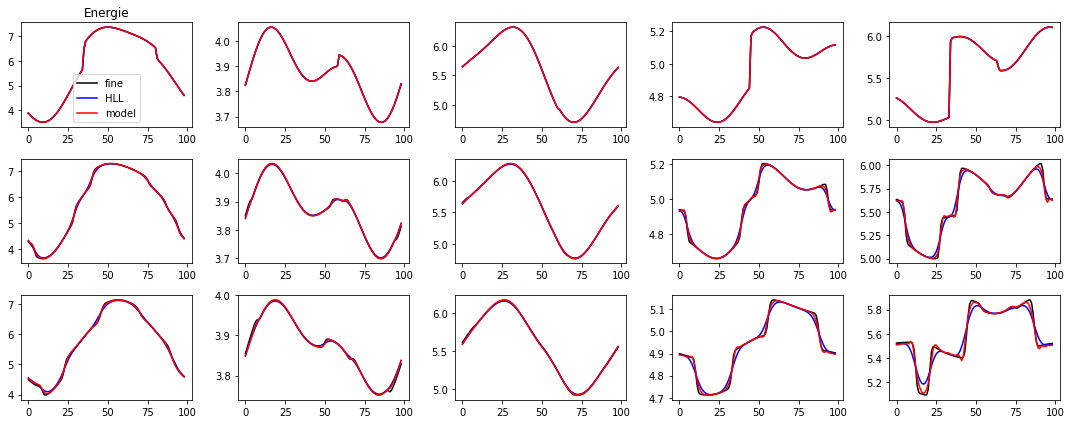

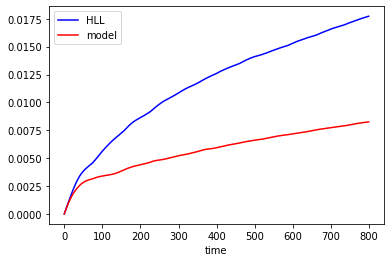

In [ ]:
param.BC_model=param.BC_solver=Param.BC_periodic 
w_init=init_periodic(param,50)
W_val = core.compute_solutions(param, nb_t, w_init,False)
print(W_val.shape)
compare_along_the_time(W_val)

traçage de la fonction 'compute_solutions_order1' avec les arguments primitif:
		 nb_t,dt_over_dx,dt_over_dx_coarse,nx,nx_coarse,BC_solver,gamma,is_coarse=
		 800 0.1 0.009899999999999999 1000 99 reflexive 1.4 False
		 et le tenseurs W_init de shape: (50, 1000, 3)
(800, 50, 1000, 3)
traçage de la méthode _predict_accelerated avec les arguments primitifs
		is_model,  BC_solver, gamma, dt_over_dx_coarse
		 True reflexive 1.4 0.009899999999999999
		et le tenseur w_init de shape (50, 99, 3)
traçage de la méthode _predict_accelerated avec les arguments primitifs
		is_model,  BC_solver, gamma, dt_over_dx_coarse
		 False reflexive 1.4 0.009899999999999999
		et le tenseur w_init de shape (50, 99, 3)


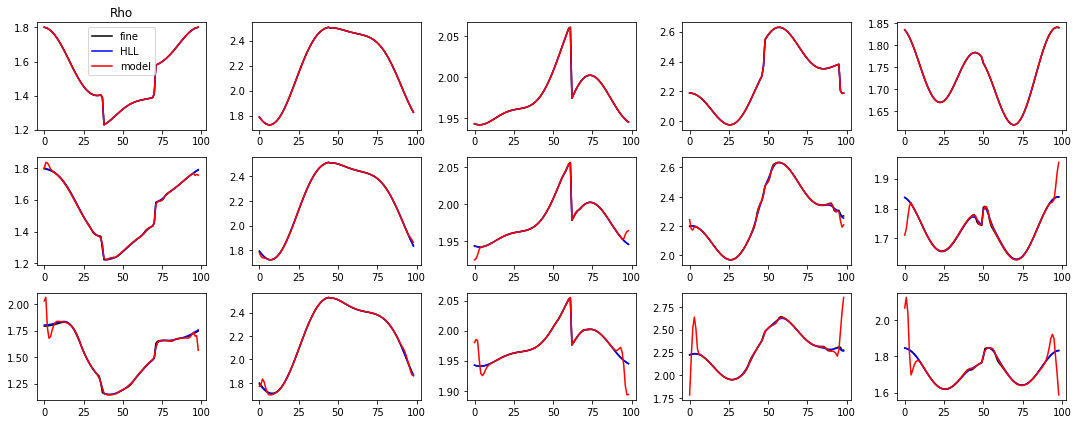

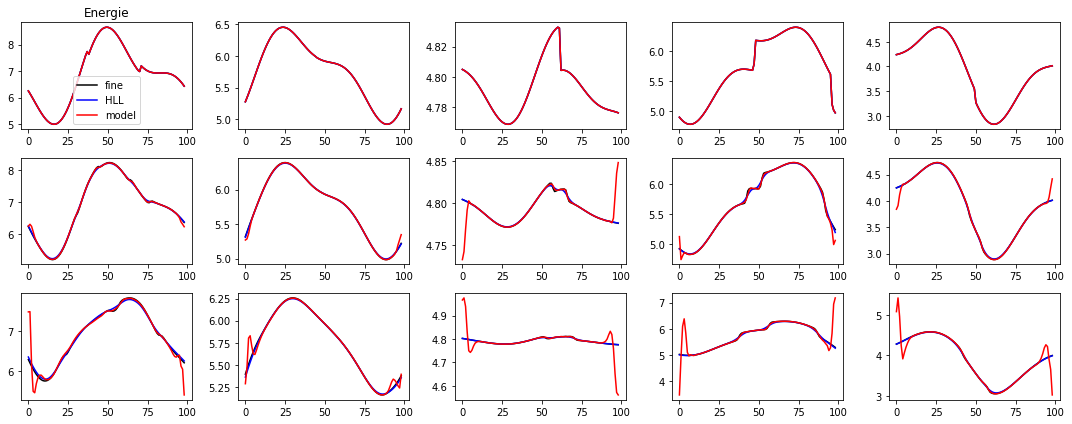

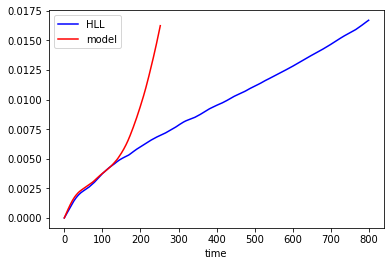

In [ ]:
param.BC_model=param.BC_solver=Param.BC_reflexive
w_init=init_periodic(param,50)
W_val = core.compute_solutions(param, nb_t, w_init,False)
print(W_val.shape)
compare_along_the_time(W_val)

### kind non-periodic

In [ ]:
param.BC_model=param.BC_solver=Param.BC_neumann 

In [ ]:
w_init=init_non_periodic(param,50)
W_val = core.compute_solutions(param, nb_t, w_init,False)
W_val.shape

traçage de la fonction 'compute_solutions_order1' avec les arguments primitif:
		 nb_t,dt_over_dx,dt_over_dx_coarse,nx,nx_coarse,BC_solver,gamma,is_coarse=
		 800 0.1 0.009899999999999999 1000 99 neumann 1.4 False
		 et le tenseurs W_init de shape: (50, 1000, 3)


TensorShape([800, 50, 1000, 3])

traçage de la méthode _predict_accelerated avec les arguments primitifs
		is_model,  BC_solver, gamma, dt_over_dx_coarse
		 True neumann 1.4 0.009899999999999999
		et le tenseur w_init de shape (50, 99, 3)
traçage de la méthode _predict_accelerated avec les arguments primitifs
		is_model,  BC_solver, gamma, dt_over_dx_coarse
		 False neumann 1.4 0.009899999999999999
		et le tenseur w_init de shape (50, 99, 3)


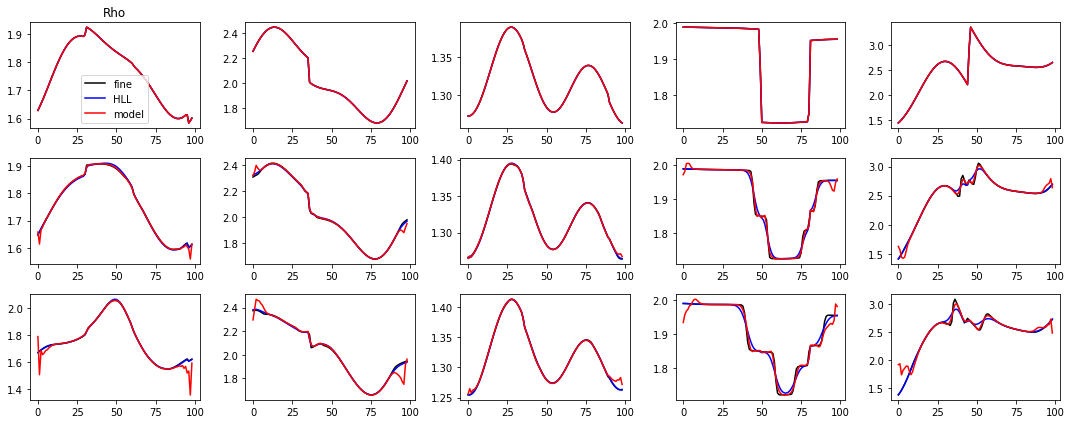

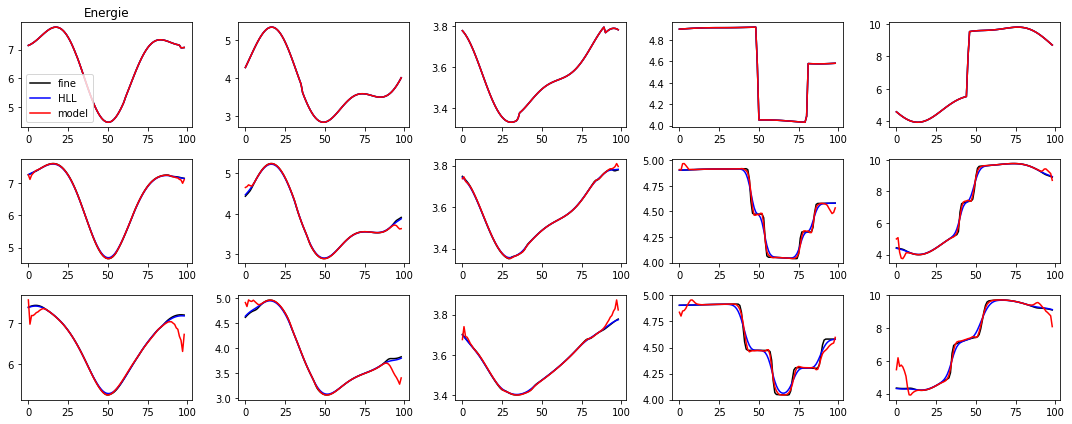

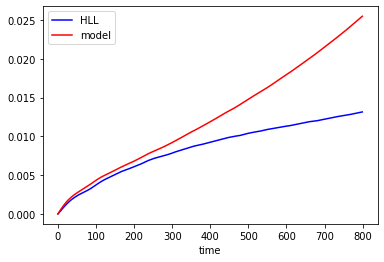

In [ ]:
compare_along_the_time(W_val)

### kind Sod

In [ ]:
def deterministic_SOD(batch_size):
    x = tf.range(param.xmin, param.xmax, param.dx)
            
    #La densité peu être assez faible: 0.1 OK, 0.01-> quelques oscilations
    rho_0 =  tf.where(x < 0.5, 1., 0.5 )+1 #0.125
    #Par contre la pression ne doit pas proche de zéro: avec 0.01 cela craque tout de suite
    P_0 =    tf.where(x < 0.5, 1., 0.5)+1 #0.1
    P_coefs=np.linspace(1,3,batch_size)

    rho=[rho_0 for _ in range(batch_size)]
    #rho=[rho_0*coef for coef in P_coefs]
    P=np.array([P_0*coef for coef in P_coefs])

    rhoV = tf.zeros([batch_size, param.nx])
    E=P#/(param.gamma-1)

    return np.stack([rho,rhoV,E],axis=2)

In [ ]:
#w_init=random_SOD(5)
w_init=deterministic_SOD(5)

param.BC_model=param.BC_solver=param.BC_neumann
W_val = core.compute_solutions(param, nb_t, w_init,False)
W_val.shape

traçage de la fonction 'compute_solutions_order1' avec les arguments primitif:
		 nb_t,dt_over_dx,dt_over_dx_coarse,nx,nx_coarse,BC_solver,gamma,is_coarse=
		 800 0.1 0.009899999999999999 1000 99 neumann 1.4 False
		 et le tenseurs W_init de shape: (5, 1000, 3)


TensorShape([800, 5, 1000, 3])

traçage de la méthode _load_WY_accelerated2 pour les paramètres: W:(800, 5, 1000, 3), nx_ratio:10
traçage de la méthode _predict_accelerated avec les arguments primitifs
		is_model,  BC_solver, gamma, dt_over_dx_coarse
		 True neumann 1.4 0.009899999999999999
		et le tenseur w_init de shape (5, 99, 3)
traçage de la méthode _predict_accelerated avec les arguments primitifs
		is_model,  BC_solver, gamma, dt_over_dx_coarse
		 False neumann 1.4 0.009899999999999999
		et le tenseur w_init de shape (5, 99, 3)


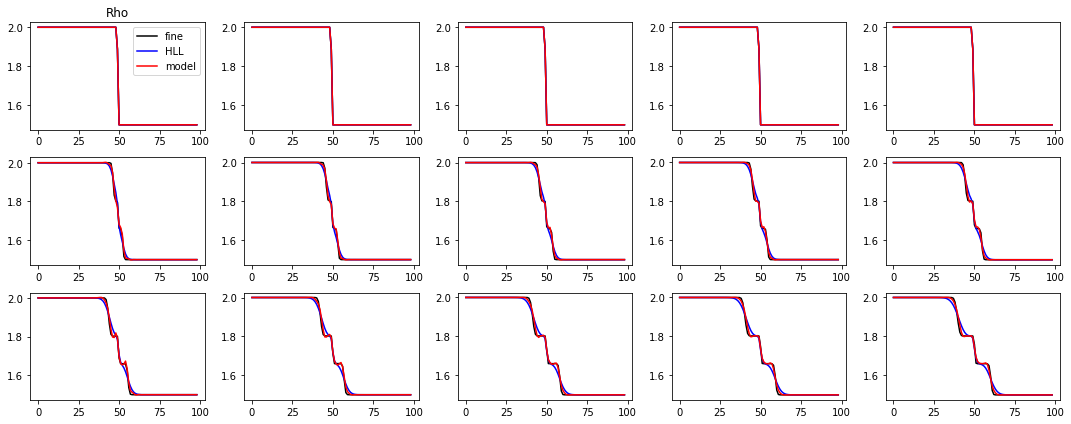

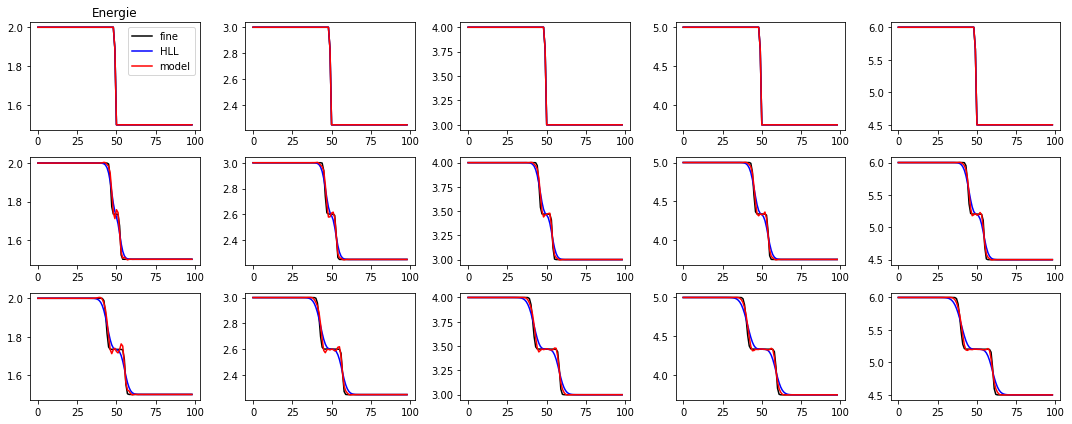

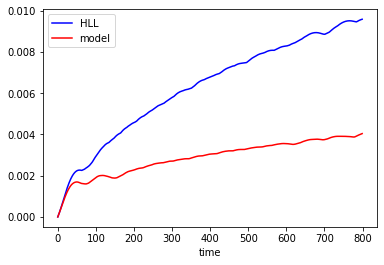

In [ ]:
compare_along_the_time(W_val)